<a href="https://colab.research.google.com/github/jyothsnashaji/Image-Reconstruction/blob/master/SART_%2B_CNN_PART_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install pydicom


     |████████████████████████████████| 35.3MB 89kB/s 


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from google.colab import drive
drive.flush_and_unmount()


In [0]:
import pydicom
import numpy as np
from skimage import morphology
from scipy import ndimage
import os
import matplotlib.pyplot as plt
from skimage.transform import radon, rescale,iradon_sart,iradon

path='/content/drive/My Drive/Major Project/'


In [0]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept

    return hu_image

def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

def remove_noise(file_path, display=False):
    medical_image = pydicom.read_file(file_path,force=True)
    medical_image.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian

    image = medical_image.pixel_array
    
    hu_image = transform_to_hu(medical_image, image)
    brain_image = window_image(hu_image, window_lower, window_upper)
    # morphology.dilation creates a segmentation of the image
    # If one pixel is between the origin and the edge of a square of size
    # 5x5, the pixel belongs to the same class
    
    # We can instead use a circule using: morphology.disk(2)
    # In this case the pixel belongs to the same class if it's between the origin
    # and the radius
    
    segmentation = morphology.dilation(brain_image, np.ones((4, 4)))
    labels, label_nb = ndimage.label(segmentation)
    
    label_count = np.bincount(labels.ravel().astype(np.int))
    # The size of label_count is the number of classes/segmentations found
    
    # We don't use the first class since it's the background
    label_count[0] = 0
    
    # We create a mask with the class with more pixels
    # In this case should be the brain
    mask = labels == label_count.argmax()
    
    # Improve the brain mask
    mask = morphology.dilation(mask, np.ones((4, 4)))
    mask = ndimage.morphology.binary_fill_holes(mask)
    mask = morphology.dilation(mask, np.ones((2, 2)))
    
    # Since the the pixels in the mask are zero's and one's
    # We can multiple the original image to only keep the brain region
    masked_image = mask * brain_image

    if display:
        plt.figure(figsize=(30, 5))
        plt.subplot(141)
        plt.imshow(brain_image,cmap=plt.cm.Greys_r)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(142)
        plt.imshow(mask,cmap=plt.cm.Greys_r)
        plt.title('Mask')
        plt.axis('off')

        plt.subplot(143)
        plt.imshow(masked_image,cmap=plt.cm.Greys_r)
        plt.title('Final Image')
        plt.axis('off')
    
    return masked_image

In [0]:


window_lower=40
window_upper=80

folder = os.fsencode(path+'FullDicom')
for file in os.listdir(folder):
  filename=os.fsdecode(file)
  medical_image = pydicom.read_file(path+'FullDicom/'+filename,force=True)
  medical_image.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
  image = medical_image.pixel_array
  hu_image = transform_to_hu(medical_image,image)
  brain_image = window_image(hu_image, window_lower, window_upper)
 # bone_image = window_image(hu_image, 400, 1000)
  noise_removed=remove_noise(path+'FullDicom/'+filename, display=False)
  fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(16, 9))
  fig.suptitle(filename)
  ax1.set_title('Original')
  ax1.imshow(hu_image, cmap=plt.cm.Greys_r)
  ax2.set_title('Preprocessed')
  ax2.imshow(brain_image, cmap=plt.cm.Greys_r)
  ax3.set_title('Noise Removed')
  ax3.imshow(noise_removed, cmap=plt.cm.Greys_r)
  np.save(path+'Preprocessed/'+filename[:-3]+'npy',noise_removed)
  #image=np.load(path+'/Preprocessed/'+filename[:-3]+'npy')
  #ax4.imshow(image, cmap=plt.cm.Greys_r)
  

  


Taking Sparse Projections and reconstructing image

In [0]:
#@title

downfactor= 100 # Number of angles taken
sart_iterations=2 # Number of iterations of SART
window_lower=40
window_upper=80
folder = os.fsencode(path+'FullDicom/')

for file in os.listdir(folder):
  filename = os.fsdecode(file)

  ds=pydicom.dcmread(path+'FullDicom/'+filename,force=True)
  ds.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
  image=ds.pixel_array
  print(filename)
  theta = np.linspace(0., 180., downfactor, endpoint=False)
  sinogram = radon(image, theta=theta,preserve_range=True)
  sart=iradon_sart(sinogram, theta=theta)
  for x in range(1,sart_iterations):
    sart = iradon_sart(sinogram, theta=theta,image=sart)
  hu_image=transform_to_hu(ds,image)
  brain_image = window_image(hu_image, window_lower, window_upper)
  np.save(path+'SparseRecon/'+filename[:-3]+'npy',brain_image)
  
  



Image Generator

In [0]:
#@title
from tensorflow import keras

class ImageGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, data_dir, batch_size = 32, x_dim=(512,512,1), y_dim=(512,512,1), shuffle=True):
        self.list_IDs = list_IDs
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.list_IDs)/self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_IDs = [self.list_IDs[k] for k in batch_indexes]
        
        X, Y = self.__batch_data_generation(batch_IDs)
        
        return X,Y
    
    def __batch_data_generation(self, batch_IDs):
        X = np.empty((self.batch_size, *self.x_dim)) #* is used to unpack the self.dim tuple
        Y = np.empty((self.batch_size, *self.y_dim))
        
        for i, ID in enumerate(batch_IDs):
            X[i,:], Y[i,:] = self.load_mat(ID)
            
        return X,Y
    
    def load_mat(self, ID):
        filename =  str(ID)
        input=np.load(self.data_dir+'/SparseRecon/'+filename+'.npy')
        target=np.load(self.data_dir+'/Preprocessed/'+filename + '.npy')

        input = np.reshape(input, self.x_dim)
        target = np.reshape(target, self.y_dim)
        return input,target

if __name__ == '__main__':
   
    generator = ImageGenerator(list(np.arange(1, 11)), path)
    #print(generator.load_mat(5))

U-Net

In [0]:
#@title
from tensorflow  import keras

def UNet(input_size, pretrained_weights = None):
    inputs = keras.Input(shape = input_size)
    
    #level 1
    conv64_1 = keras.layers.Conv2D(64, [3,3], [1,1], 'same', activation = 'relu')(inputs)
    conv64_1_BN = keras.layers.BatchNormalization()(conv64_1)
    conv64_2 = keras.layers.Conv2D(64, [3,3], [1,1], 'same', activation = 'relu')(conv64_1_BN)
    conv64_2_BN = keras.layers.BatchNormalization()(conv64_2)
    conv64_3 = keras.layers.Conv2D(64, [3,3], [1,1], 'same', activation = 'relu')(conv64_2_BN)
    conv64_3_BN = keras.layers.BatchNormalization()(conv64_3)
    
    #downsampling to level 2
    conv64_3_pool = keras.layers.MaxPool2D([2,2], padding = 'valid')(conv64_3_BN)
    conv128_1 = keras.layers.Conv2D(128, [3,3], [1,1], 'same', activation = 'relu')(conv64_3_pool)
    conv128_1_BN = keras.layers.BatchNormalization()(conv128_1)
    conv128_2 = keras.layers.Conv2D(128, [3,3], [1,1], 'same', activation = 'relu')(conv128_1_BN)
    conv128_2_BN = keras.layers.BatchNormalization()(conv128_2)
    
    #downsampling to level 3
    conv128_2_pool = keras.layers.MaxPool2D([2,2], padding = 'valid')(conv128_2_BN)
    conv256_1 = keras.layers.Conv2D(256, [3,3], [1,1], 'same', activation = 'relu')(conv128_2_pool)
    conv256_1_BN = keras.layers.BatchNormalization()(conv256_1)
    conv256_2 = keras.layers.Conv2D(256, [3,3], [1,1], 'same', activation = 'relu')(conv256_1_BN)
    conv256_2_BN = keras.layers.BatchNormalization()(conv256_2)
    
    #downsampling to level 4
    conv256_2_pool = keras.layers.MaxPool2D([2,2], padding = 'valid')(conv256_2_BN)
    conv512_1 = keras.layers.Conv2D(512, [3,3], [1,1], 'same', activation = 'relu')(conv256_2_pool)
    conv512_1_BN = keras.layers.BatchNormalization()(conv512_1)
    conv512_2 = keras.layers.Conv2D(512, [3,3], [1,1], 'same', activation = 'relu')(conv512_1_BN)
    conv512_2_BN = keras.layers.BatchNormalization()(conv512_2)
    
    #downsampling to level 5
    conv512_2_pool = keras.layers.MaxPool2D([2,2], padding = 'valid')(conv512_2_BN)
    conv1024_1 = keras.layers.Conv2D(1024, [3,3], [1,1], 'same', activation = 'relu')(conv512_2_pool)
    conv1024_1_BN = keras.layers.BatchNormalization()(conv1024_1)
    conv1024_2 = keras.layers.Conv2D(1024, [3,3], [1,1], 'same', activation = 'relu')(conv1024_1_BN)
    conv1024_2_BN = keras.layers.BatchNormalization()(conv1024_2)
    
    #upsampling to level 4
    level4_ini = keras.layers.Conv2D(512, [3,3], [1,1], 'same', activation='relu')(keras.layers.UpSampling2D((2,2))(conv1024_2_BN))
    level4_ini_concat = keras.layers.concatenate([conv512_2_BN, level4_ini], axis = -1)
    conv512_1_up = keras.layers.Conv2D(512, [3,3], [1,1], 'same', activation = 'relu')(level4_ini_concat)
    conv512_1_BN_up = keras.layers.BatchNormalization()(conv512_1_up)
    conv512_2_up = keras.layers.Conv2D(512, [3,3], [1,1], 'same', activation = 'relu')(conv512_1_BN_up)
    conv512_2_BN_up = keras.layers.BatchNormalization()(conv512_2_up)
    
    #upsampling to level 3
    level3_ini = keras.layers.Conv2D(256, [3,3], [1,1], 'same', activation='relu')(keras.layers.UpSampling2D((2,2))(conv512_2_BN_up))
    level3_ini_concat = keras.layers.concatenate([conv256_2_BN, level3_ini], axis = -1)
    conv256_1_up = keras.layers.Conv2D(256, [3,3], [1,1], 'same', activation = 'relu')(level3_ini_concat)
    conv256_1_BN_up = keras.layers.BatchNormalization()(conv256_1_up)
    conv256_2_up = keras.layers.Conv2D(256, [3,3], [1,1], 'same', activation = 'relu')(conv256_1_BN_up)
    conv256_2_BN_up = keras.layers.BatchNormalization()(conv256_2_up)
    
    #upsampling to level 2
    level2_ini = keras.layers.Conv2D(128, [3,3], [1,1], 'same', activation='relu')(keras.layers.UpSampling2D((2,2))(conv256_2_BN_up))
    level2_ini_concat = keras.layers.concatenate([conv128_2_BN, level2_ini], axis = -1)
    conv128_1_up = keras.layers.Conv2D(128, [3,3], [1,1], 'same', activation = 'relu')(level2_ini_concat)
    conv128_1_BN_up = keras.layers.BatchNormalization()(conv128_1_up)
    conv128_2_up = keras.layers.Conv2D(128, [3,3], [1,1], 'same', activation = 'relu')(conv128_1_BN_up)
    conv128_2_BN_up = keras.layers.BatchNormalization()(conv128_2_up)
    
    #upsampling to level 1
    level1_ini = keras.layers.Conv2D(64, [3,3], [1,1], 'same', activation='relu')(keras.layers.UpSampling2D((2,2))(conv128_2_BN_up))
    level1_ini_concat = keras.layers.concatenate([conv64_3_BN, level1_ini], axis = -1)
    conv64_1_up = keras.layers.Conv2D(64, [3,3], [1,1], 'same', activation = 'relu')(level1_ini_concat)
    conv64_1_BN_up = keras.layers.BatchNormalization()(conv64_1_up)
    conv64_2_up = keras.layers.Conv2D(64, [3,3], [1,1], 'same', activation = 'relu')(conv64_1_BN_up)
    conv64_2_BN_up = keras.layers.BatchNormalization()(conv64_2_up)
    conv1_up = keras.layers.Conv2D(1, [1,1], [1,1], 'same')(conv64_2_BN_up)
    outputs = keras.layers.add([inputs, conv1_up])
    
    
    ###################################################################################
    model = keras.models.Model(inputs = inputs, outputs = outputs)
    if pretrained_weights:
        model.load_weights(pretrained_weights)
    
    return model

if __name__ == '__main__':
    model = UNet((512,512,1))
    #model.summary()
    

Plots

In [0]:
#@title
from matplotlib import pyplot as plt
from IPython.display import clear_output
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        #self.acc = []
        #self.val_acc = []
        self.ssim=[]
        self.psnr=[]
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.ssim.append(logs.get('ssim_loss'))
        self.psnr.append(logs.get('psnr'))
        #self.acc.append(logs.get('acc'))
        #self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(16,8), sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.set_ylabel('MSE')
        ax1.set_xlabel('Epoch')
        ax1.legend()
        
        ax2.plot(self.x, self.ssim, label="ssim")
        ax2.set_ylabel('SSIM')
        ax2.set_xlabel('Epoch')
        ax2.legend()
        
        ax3.plot(self.x, self.psnr, label="psnr")
        ax3.set_ylabel('PSNR')
        ax3.set_xlabel('Epoch')
        ax3.legend()
    
        plt.savefig(path+'graph100.png')
        plt.show()

        
plot = PlotLearning()

Metrics for Evaluation

In [0]:
#@title
import tensorflow as tf
from keras import backend

 
# Structural Similarity Index
def ssim_loss(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 255))

# Peak Signal To Noise Ratio
def psnr(y_true, y_pred):
  return tf.reduce_mean(tf.image.psnr(y_true, y_pred, 255))


Using TensorFlow backend.


Training

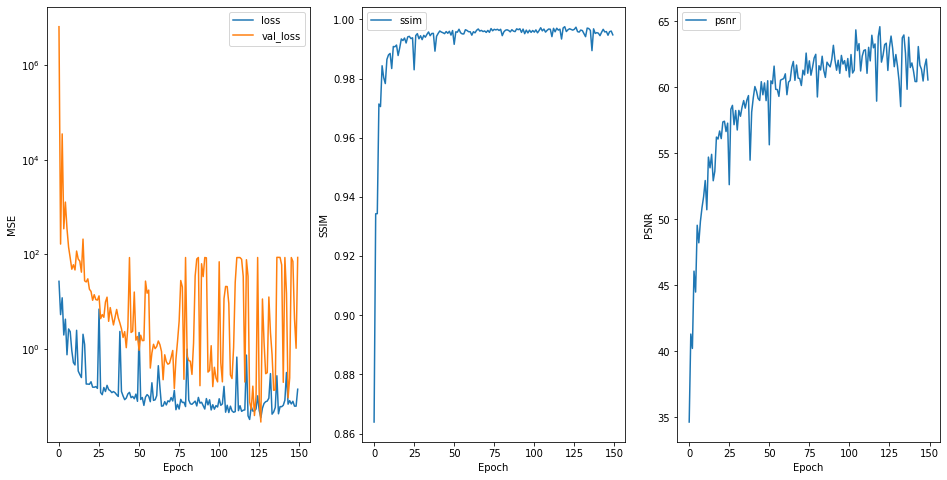

20/20 [==============================] - 35s 2s/step - loss: 0.1401 - ssim_loss: 0.9948 - psnr: 60.5693 - val_loss: 85.8311 - val_ssim_loss: 0.9605 - val_psnr: 28.7946


In [0]:
#@title


train_IDs = list(np.arange(1, 41))
val_IDs = list(np.arange(41, 51))
train_generator = ImageGenerator(train_IDs, path, batch_size = 2)
val_generator = ImageGenerator(val_IDs, path, batch_size = 2)

model = UNet((512,512,1))
model.compile(optimizer = 'rmsprop', loss = 'mean_squared_error', metrics = [ssim_loss,psnr])
history= model.fit_generator(train_generator, epochs = 150, validation_data = val_generator,
                    workers = 6, callbacks = [plot])
model.save(path+"modelsart100.h5")